In [832]:
import os

import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
import gensim
from gensim.models import word2vec

from glove import glove
from glove import corpus

from sklearn import svm,neighbors,ensemble,linear_model, naive_bayes, cluster
from sklearn.model_selection import train_test_split,ShuffleSplit,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, label_binarize
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,silhouette_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.manifold import TSNE

from wordcloud import WordCloud

from collections import Counter

%matplotlib inline

import warnings

warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings("ignore",category=DeprecationWarning)


sns.set(style='darkgrid',context='talk',palette='inferno')

In [770]:
#directory where closed captioning XML files are located
path = '/root/Desktop/gits/ds-unit4/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([os.fsdecode(file) for file in os.listdir(folder)])

#extract text from xml file
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)


In [771]:
#Create data frame for dataset, load each lecture text with the filename

In [772]:
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = lecture_texts

In [773]:
print(type(raw_data.raw_text[0]))
raw_data.head(2)

<class 'list'>


filename                                           raw_text
0   aurouxmcalc1.xml  [So let's start right away with\nstuff that we...
1  aurouxmcalc11.xml  [The following content is\nprovided under a Cr...

In [774]:
#look at sample
print(raw_data.raw_text[0][:5])

["So let's start right away with\nstuff that we will need to see", 'before we can go on to more\nadvanced things.', 'So, hopefully yesterday in\nrecitation, you heard a bit', 'about vectors.\nHow many of you actually knew', "about vectors before that?\nOK, that's the vast majority."]


In [775]:
#converts list of strings to larger string
raw_data.raw_text = [' '.join(i) for i in raw_data.raw_text]
print(type(raw_data.raw_text[0]))
raw_data.head(2)

<class 'str'>


filename                                           raw_text
0   aurouxmcalc1.xml  So let's start right away with\nstuff that we ...
1  aurouxmcalc11.xml  The following content is\nprovided under a Cre...

In [840]:
#extend range, visually inspect text
chars_per_lecture = 10
for i in raw_data.raw_text:
    print(i[:chars_per_lecture])

So let's s
 So far we
So , So, y
 So, so fa
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
 PROFESSOR
 PROFESSOR
The follow
The follow
 PROFESSOR
The follow
The follow
The follow
PROFESSOR:
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
The follow
 Okay, so 
 Okay, so 
 All right
OK, let's 
I just rec
The topic 
This time,
The topic 
I assume f
This is al
I usually 
We're goin
 PROFESSOR
The follow
 PROFESSOR
The follow
The follow
 PROFESSOR
The follow
 PROFESSOR
 PROFESSOR
The follow
 Network, 
 All right
 Alright! 
>>  About 
Hi. This i
OK, here i
2 times th
I've been 
Okay, this
Okay. This
Okay. This
OK, here's
OK, when t
OK, this i
 PROFESSOR
The follow
The follow
The follow
The follow
The follow
The follow
The follow
PROFESSOR:
PROFESSOR:
The follow
PROFESSOR:
What we're
PROFESSOR:
PROFESSOR:

In [777]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. Your support will help MIT OpenCourseWare continue to offer high quality educational resources for free. To make a donation or to view additional materials from hundreds of MIT courses, visit MIT OpenCourseWare at ocw.mit.edu.",'',text)
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    return text

In [778]:
#clean each lecture text
raw_data.raw_text = [text_cleaner(i) for i in raw_data.raw_text]
raw_data.head(2)

filename                                           raw_text
0   aurouxmcalc1.xml  So let's start right away with stuff that we w...
1  aurouxmcalc11.xml   So far we have learned about partial derivati...

In [779]:
#label professors
professors = ['Auroux']*4 + ['Demaine']*4 + ['Devadas']*9 + ['Jerison']*8 + ['Leighton']*11 + ['Manning']*8 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*17 + ['Winston']* 8

In [780]:
#label_subjects
subjects = ['Calculus']*4 + ['Data']*4 + ['Algorithms']*9 + ['Calculus']*8 + ['CS Math']*11 + ['NLP']*8\
+ ['Differential Equations']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 7 +\
['AI']*8

In [781]:
#add to raw_data
raw_data['Professor'] = professors
raw_data['Subject'] = subjects

In [782]:
raw_data.head(10)

filename                                           raw_text  \
0   aurouxmcalc1.xml  So let's start right away with stuff that we w...   
1  aurouxmcalc11.xml   So far we have learned about partial derivati...   
2   aurouxmcalc2.xml  So , So, yesterday we learned about the questi...   
3   aurouxmcalc5.xml   So, so far, we've seen things about vectors, ...   
4   demainedata1.xml  The following content is provided under a Crea...   
5  demainedata11.xml  The following content is provided under a Crea...   
6  demainedata14.xml  The following content is provided under a Crea...   
7  demainedata15.xml  The following content is provided under a Crea...   
8   demainedata2.xml  The following content is provided under a Crea...   
9   demainedata5.xml  The following content is provided under a Crea...   

  Professor     Subject  
0    Auroux    Calculus  
1    Auroux    Calculus  
2    Auroux    Calculus  
3    Auroux    Calculus  
4   Demaine        Data  
5   Demaine        Data  
6   Demaine        Data  
7   Demaine        Data  
8   Devadas  Algorithms  
9   Devadas  Algorithms

In [783]:
#create spacy doc for each lecture
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]

In [784]:
type(raw_data.sdoc[0])

spacy.tokens.doc.Doc

In [785]:
raw_data.head(2)

filename                                           raw_text  \
0   aurouxmcalc1.xml  So let's start right away with stuff that we w...   
1  aurouxmcalc11.xml   So far we have learned about partial derivati...   

  Professor   Subject                                               sdoc  
0    Auroux  Calculus  (So, let, 's, start, right, away, with, stuff,...  
1    Auroux  Calculus  ( , So, far, we, have, learned, about, partial...

In [786]:
#create a new data frame to break the lectures down by sentence
to_sentences = raw_data[['Professor','Subject','sdoc']].copy()

In [787]:
#create list of lists sentences for each lecture
import time
sta = time.time()
sents1 =[]
for doc in to_sentences.sdoc:
    sents = []
    for sent in doc.sents:
        sent = [token.lemma_.lower()
        for token in sent
        if not token.is_stop
        and not token.is_punct]
        sents.append((sent))
    sents1.append(sents)
st = time.time()
st-sta

1.9152436256408691

In [788]:
sta = time.time()
lcsents = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in to_sentences.sdoc]
st = time.time()
st-sta

1.135690689086914

In [789]:
sents1 == lcsents

True

In [790]:
to_sentences['sents'] = lcsents
to_sentences.drop(['sdoc'],1,inplace=True)
to_sentences.head()

Professor   Subject                                              sents
0    Auroux  Calculus  [[so, let, -pron-, start, right, away, stuff, ...
1    Auroux  Calculus  [[ , so, far, learn, partial, derivative, use,...
2    Auroux  Calculus  [[so, so, yesterday, learn, question, plane, t...
3    Auroux  Calculus  [[ , so, far, have, see, thing, vector, equati...
4   Demaine      Data  [[the, follow, content, provide, creative, com...

In [791]:
#vectorized solution to explode the df so that each sentences is identified with professor and subject
sentences = pd.DataFrame({
         col:np.repeat(to_sentences[col].values, to_sentences['sents'].str.len())
         for col in to_sentences.columns.difference(['sents'])
         }).assign(**{'sents':np.concatenate(to_sentences['sents'].values)})[to_sentences.columns.tolist()]

In [792]:
print(sentences.shape)
sentences.head()

(66224, 3)


Professor   Subject                                              sents
0    Auroux  Calculus  [so, let, -pron-, start, right, away, stuff, n...
1    Auroux  Calculus  [so, hopefully, yesterday, recitation, hear, b...
2    Auroux  Calculus                      [how, actually, know, vector]
3    Auroux  Calculus                           [ok, be, vast, majority]
4    Auroux  Calculus  [if, people, hopefully, will, learn, vector, r...

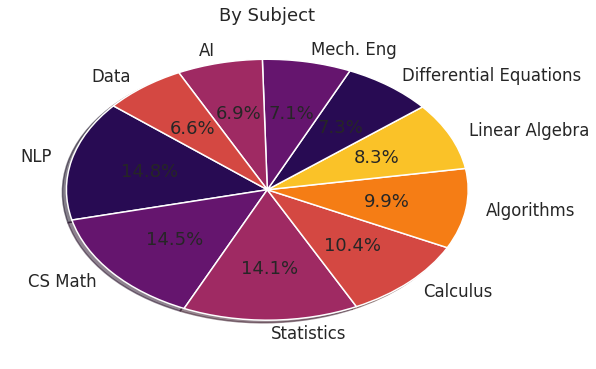

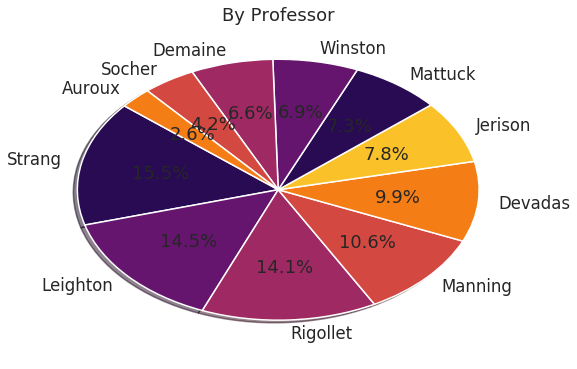

In [793]:
by_sub = sentences['Subject'].value_counts()
by_prof = sentences['Professor'].value_counts()
labels = by_sub.index
plt.figure(figsize=(9,6))
plt.pie(by_sub, autopct='%1.1f%%',labels=by_sub.index, shadow=True, startangle=140)

plt.title('By Subject')
plt.show()

plt.figure(figsize=(9,6))
plt.pie(by_prof, autopct='%1.1f%%',labels=by_prof.index, shadow=True, startangle=140)

plt.title('By Professor')
plt.show()

In [794]:
sentences.head()

Professor   Subject                                              sents
0    Auroux  Calculus  [so, let, -pron-, start, right, away, stuff, n...
1    Auroux  Calculus  [so, hopefully, yesterday, recitation, hear, b...
2    Auroux  Calculus                      [how, actually, know, vector]
3    Auroux  Calculus                           [ok, be, vast, majority]
4    Auroux  Calculus  [if, people, hopefully, will, learn, vector, r...

## Using word2vec for clustering

Here we are going create a word2vec model for our corpus and vectorize each word. This will be useful for computing similarity and visualizing the results of the clustering algorithm

In [795]:
#create a list of all sentences
w2vsents = list(sentences['sents'])

In [710]:
model = word2vec.Word2Vec(
    w2vsents,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=8,  # Minimum word count threshold.
    window=5,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [152]:
#Check some querries
# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model.wv.similarity('regression', 'logistic'))
print(model.wv.similarity('vector', 'matrix'))
print(model.wv.similarity('mean', 'variance'))

# One of these things is not like the other...
print(model.wv.doesnt_match("derivative integral chain vector".split()))
print(model.wv.doesnt_match("matrix vector identity derivative".split()))
print(model.wv.doesnt_match("derivative implicit integral chain".split()))
print(model.wv.doesnt_match("explicit implicit integral IVP".split()))
print(model.wv.doesnt_match("neural regression AI machine".split()))


0.7510235
0.4188794
0.5618287
vector
derivative
integral
integral
regression


In [162]:
print(model.wv.most_similar(positive=['gaussian'], negative=[], topn=3))

[('distribution', 0.7649248838424683), ('normal', 0.7389419674873352), ('pivotal', 0.735517144203186)]


In [173]:
print(model.wv.most_similar(positive=['series'], negative=[], topn=3))

[('incorrect', 0.7952553033828735), ('terrance', 0.7810298204421997), ('game', 0.7765673398971558)]


In [161]:
print(model.wv.most_similar(positive=['distribution', 'series'], negative=['gaussian']))

[('incorrect', 0.7137490510940552), ('collision', 0.6788856387138367), ('monty', 0.6779464483261108), ('rough', 0.6772014498710632), ('hashing', 0.6683236956596375), ('team', 0.6554305553436279), ('generalization', 0.6498767137527466), ('more', 0.6384226083755493), ('randomness', 0.6377911567687988), ('inference', 0.6372931599617004)]


In [231]:
model.wv.most_similar('matrix')

[('identity', 0.6701694130897522),
 ('inverse', 0.6668306589126587),
 ('eigenvalue', 0.6636413335800171),
 ('eigenvector', 0.6628363132476807),
 ('invertible', 0.6537727117538452),
 ('diagonal', 0.650987982749939),
 ('entry', 0.6397207379341125),
 ('symmetric', 0.6263526678085327),
 ('determinant', 0.6004879474639893),
 ('elimination', 0.5975697636604309)]

In [521]:
model.wv.most_similar('derivative')

[('respect', 0.7532366514205933),
 ('differentiate', 0.6974731683731079),
 ('p2', 0.6830307245254517),
 ('w1', 0.6812889575958252),
 ('w2', 0.6806705594062805),
 ('x^n', 0.677148699760437),
 ('partial', 0.6554582118988037),
 ('namely', 0.6127032041549683),
 ('difference', 0.5959519743919373),
 ('ramp', 0.5747186541557312)]

In [273]:
#Create set for clustering with K-Means
X = model[model.wv.vocab.keys()]

In [276]:
#300 d vectors
X.shape

(2743, 300)

In [526]:
#first 10 values of 1st vector
X[0][:10]

array([-0.09437042, -0.9669399 ,  0.13253196, -0.05622176,  0.19535875,
       -0.18220183, -0.0400208 ,  0.29730666, -0.09067816, -0.4685382 ],
      dtype=float32)

In [234]:
#Use nltk built in kmeans clusterer for 10 clusters, for the number of the subjects
n_clusters=10
kclusterer = KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

In [563]:
#check output
print(assigned_clusters[:20])

[2, 5, 2, 1, 5, 6, 9, 2, 9, 2, 9, 7, 9, 7, 7, 3, 2, 2, 2, 2]


In [583]:
#create a dataframe for the words and cluster assignment
w_clust = pd.DataFrame()
w_clust['word'] =  list(model.wv.vocab.keys())
w_clust['cluster'] = assigned_clusters
w_clust.head()

word  cluster
0      so        2
1     let        5
2  -pron-        2
3   start        1
4   right        5

In [584]:
#Reduce the dimentionality of the vectors,
svd = TruncatedSVD(2)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_lsa = pd.DataFrame(lsa.fit_transform(X)).reset_index(drop=True)

In [585]:
#Reduce the dimentionality of the vectors to 170, so the TNSE has reduced noise
svd170 = TruncatedSVD(170)
lsa170 = make_pipeline(svd170, Normalizer(copy=False))
X_lsa170 = pd.DataFrame(lsa170.fit_transform(X)).reset_index(drop=True)

In [567]:
#Reduce the dimentionality of the vectors to 50, so the TNSE has reduced noise
svd50 = TruncatedSVD(50)
lsa50 = make_pipeline(svd50, Normalizer(copy=False))
X_lsa50 = pd.DataFrame(lsa50.fit_transform(X)).reset_index(drop=True)

In [568]:
tsne = TSNE(n_components=2, early_exaggeration=25, random_state=43)
np.set_printoptions(suppress=True)
#get coords of three versions of t-sne
Y00 = tsne.fit_transform(X)
Y01 = tsne.fit_transform(X_lsa50)
Y02 = tsne.fit_transform(X_lsa170)

In [586]:
#add coord to cluster dataframe
w_clust['x_svd'] = X_lsa[0]
w_clust['y_svd'] = X_lsa[1]
w_clust['x_tsne'] = Y00[:,0]
w_clust['y_tsne'] = Y00[:,1]
w_clust['x_svt50'] = Y01[:,0]
w_clust['y_svt50'] = Y01[:,1]
w_clust['x_svt170'] = Y02[:,0]
w_clust['y_svt170'] = Y02[:,1]

In [587]:
w_clust.head()

word  cluster     x_svd     y_svd     x_tsne     y_tsne   x_svt50  \
0      so        2  0.973301  0.229531  36.617855  21.312798 -6.371132   
1     let        5  0.863280  0.504725 -13.787405  23.652393 -7.747282   
2  -pron-        2  0.846207  0.532854  33.324547  20.254160 -5.838062   
3   start        1  0.997613  0.069058  21.383030  10.852227 -3.183526   
4   right        5  0.812039  0.583603  13.970319 -46.379753  6.946524   

     y_svt50   x_svt170   y_svt170  
0 -51.781952   0.749679 -45.273525  
1 -42.954918  49.346375   1.703493  
2 -50.244537   2.129501 -44.179985  
3  25.216455  45.660675 -17.504900  
4 -40.136574   2.631613 -54.506763

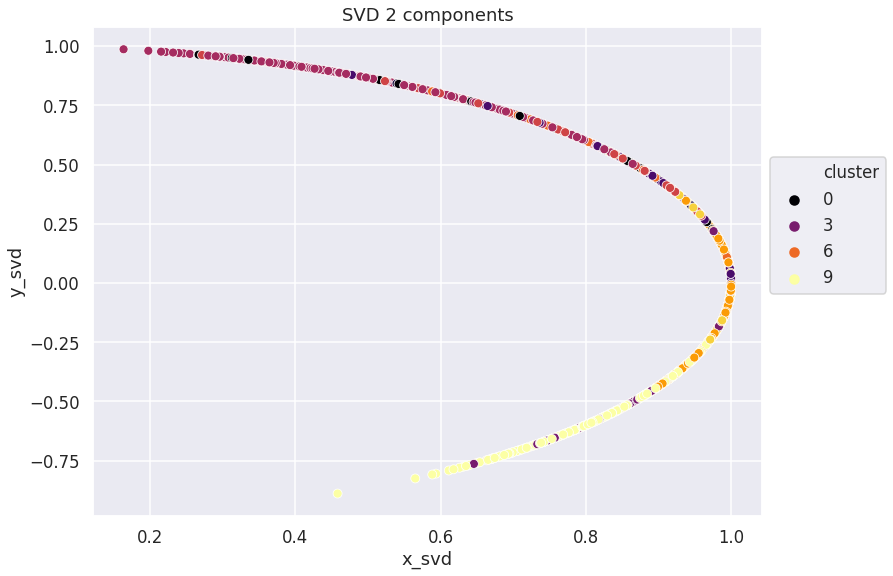

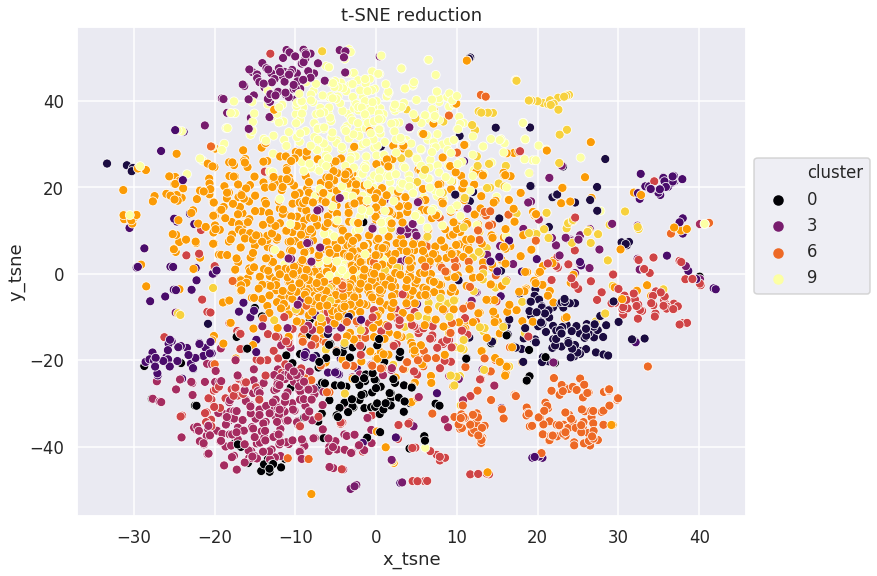

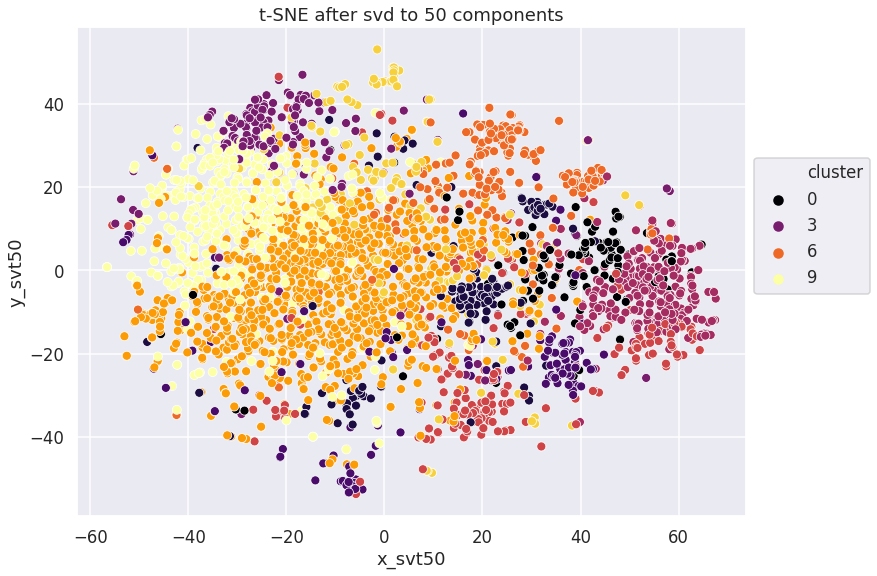

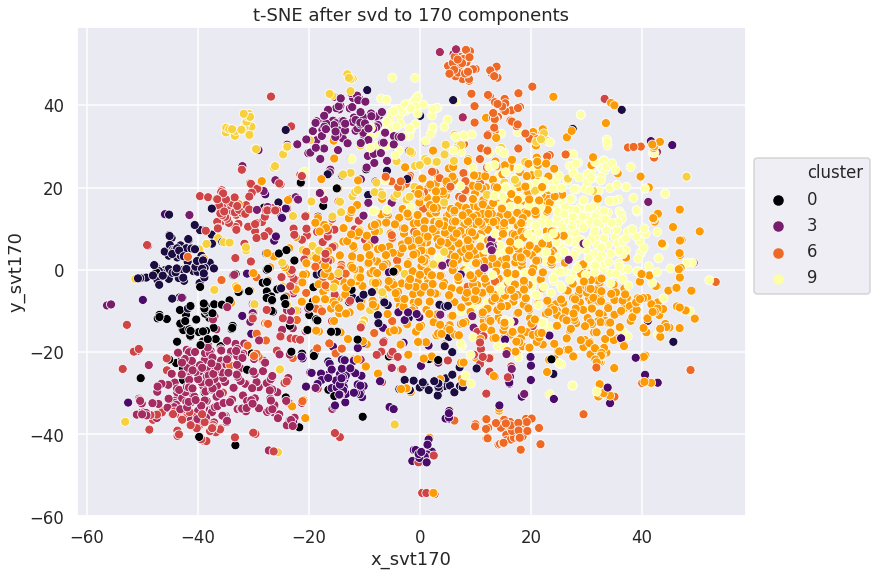

In [705]:
#plot the results
plt.figure(figsize=(12,9))
sns.scatterplot(x='x_svd',y='y_svd',hue='cluster',data=w_clust,palette='inferno')
plt.legend(bbox_to_anchor=[1, 0.75])
plt.title('SVD 2 components')
plt.show()

plt.figure(figsize=(12,9))
sns.scatterplot(x='x_tsne',y='y_tsne',hue='cluster',data=w_clust,palette='inferno')
plt.legend(bbox_to_anchor=[1, 0.75])
plt.title('t-SNE reduction')
plt.show()

plt.figure(figsize=(12,9))
sns.scatterplot(x='x_svt50',y='y_svt50',hue='cluster',data=w_clust,palette='inferno')
plt.legend(bbox_to_anchor=[1, 0.75])
plt.title('t-SNE after svd to 50 components')
plt.show()

plt.figure(figsize=(12,9))
sns.scatterplot(x='x_svt170',y='y_svt170',hue='cluster',data=w_clust,palette='inferno')
plt.legend(bbox_to_anchor=[1, 0.75])
plt.title('t-SNE after svd to 170 components')
plt.show()

## Kmeans clustering with Sk-learn

Above I used the nltk clustering for k-means. In order to apply the techniques learned in the material, i will use sci kit learn and increase the number of clusters to 11, to euqal the number of subjects.

In [592]:
#increase number of clusters to 11 for subjects
n_clusters = 11
kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[ 5  5  5 ... 10 10 10]
Centroids data
[[ 0.06261995  0.35848886 -0.20019451 ...  0.12136917  0.30889195
   0.22247618]
 [ 0.08531193  0.09792331 -0.04875261 ...  0.01576829  0.2584775
   0.1076352 ]
 [ 0.02988801  0.25607014 -0.08182823 ... -0.03670139  0.15879454
   0.11828357]
 ...
 [-0.1791352  -0.26525477 -0.05293153 ... -0.32324594  0.23436432
   0.18102627]
 [-0.13125369 -0.02559455  0.03029744 ... -0.02496355  0.07027128
  -0.00902294]
 [-0.0256074   0.10778967 -0.01712946 ... -0.02899557  0.10786481
   0.03484292]]
Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):
-18818.027
Silhouette_score: 
0.120585464


As you can see the silhouette score is pretty bad with this many of clusters. However, lets reduce the dimensionality and visualize the results

In [ ]:
sk_X = kmeans.fit_transform(X)
Yk = tsne.fit_transform(sk_X)
w_clust['xsk'] = Yk[:,0]
w_clust['ysk'] = Yk[:,1]
w_clust['sklabels'] = kmeans.labels_

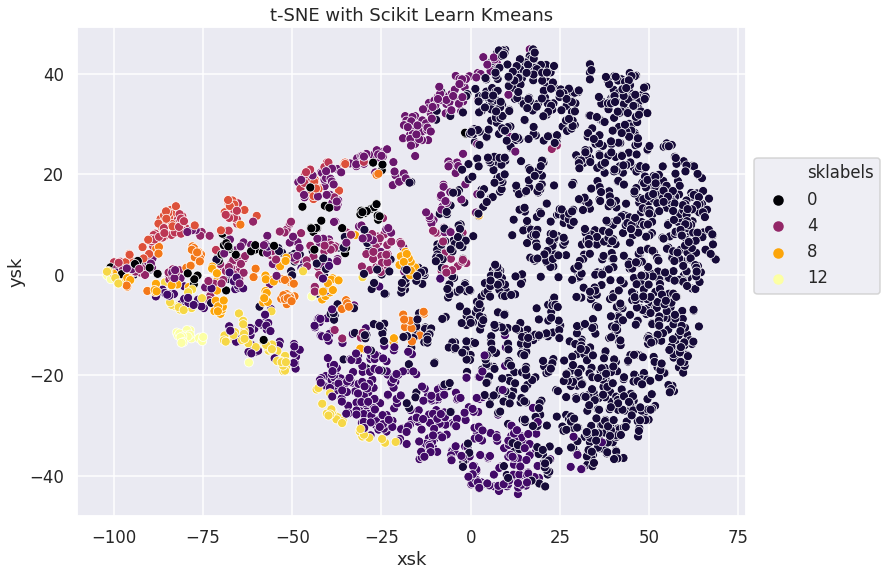

In [706]:
#Plot the results
plt.figure(figsize=(12,9))
sns.scatterplot(x='xsk',y='ysk',hue='sklabels',data=w_clust,palette='inferno')
plt.legend(bbox_to_anchor=[1, 0.75])
plt.title('t-SNE with Scikit Learn Kmeans')
plt.show()

In [599]:
#look at n members per cluster
pd.Series(labels).value_counts()

10    1456
2      450
9      357
6       92
1       76
8       69
4       68
0       62
7       50
5       39
3       24
dtype: int64

In [798]:
#Isolate clusters
c3 = w_clust[w_clust.cluster == 3]
c6 = w_clust[w_clust.cluster == 6]
c2 = w_clust[w_clust.cluster == 2]

csk3 = w_clust[w_clust.sklabels == 3]
csk6 = w_clust[w_clust.sklabels == 6]
csk2 = w_clust[w_clust.sklabels == 2]
csk7 = w_clust[w_clust.sklabels == 7]

In [721]:
w_clust[w_clust.word == 'brad']

word  cluster     x_svd     y_svd     x_tsne     y_tsne    x_svt50  \
2416  brad        6  0.985402 -0.170246  28.818256 -27.039665  18.706263   

        y_svt50   x_svt170  y_svt170        xsk        ysk  sklabels  
2416  24.016174  13.617292  36.65984 -18.521286 -12.180826         7

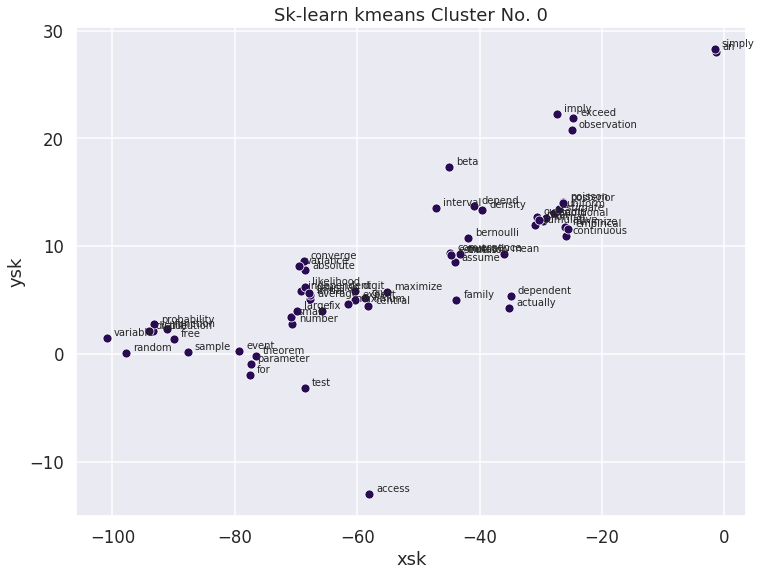

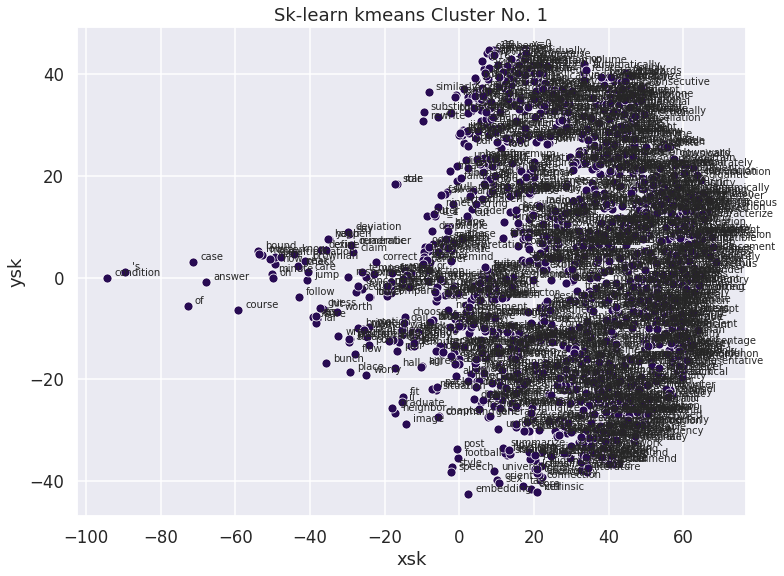

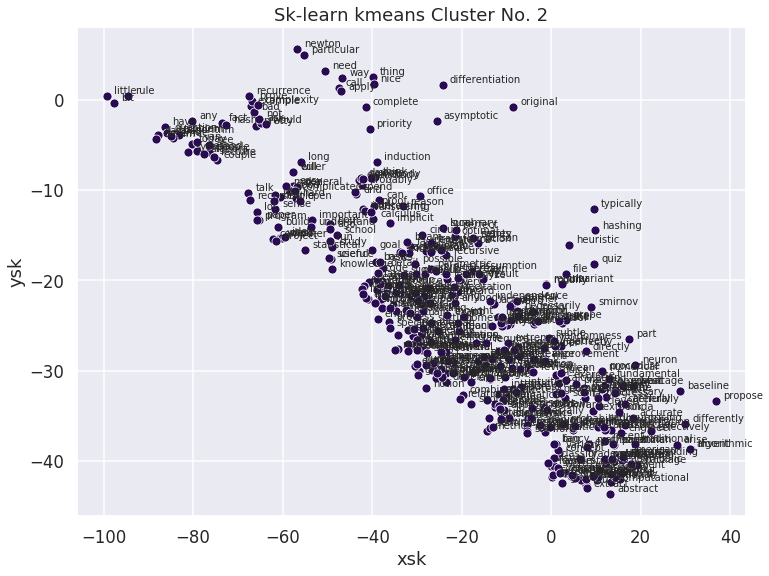

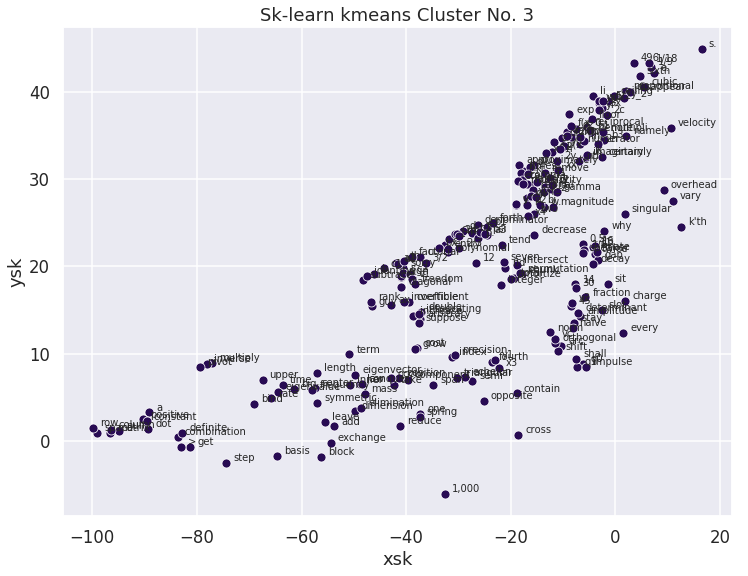

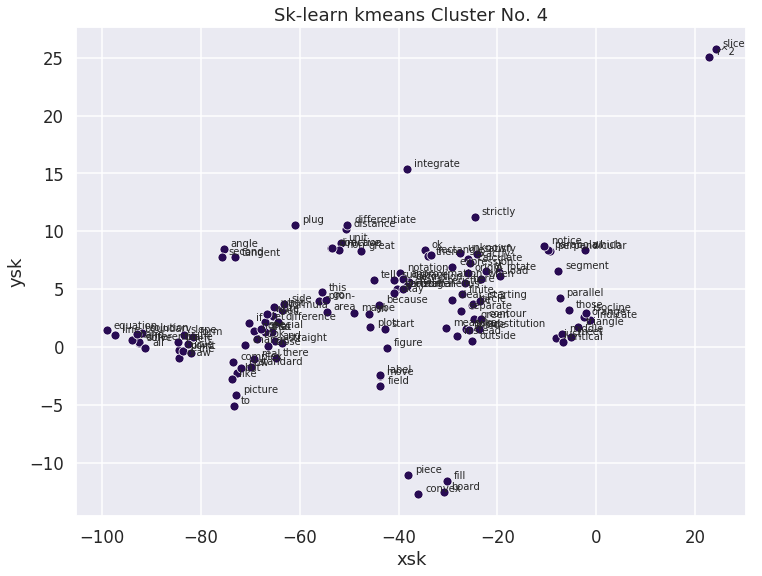

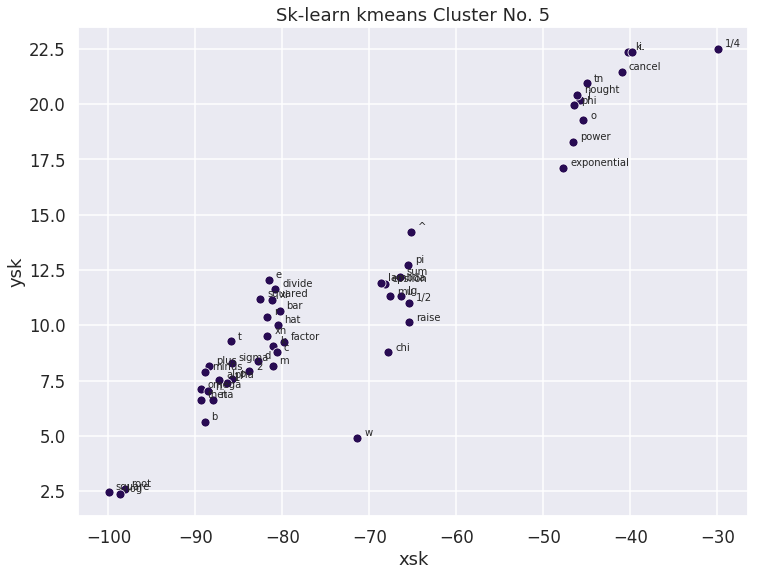

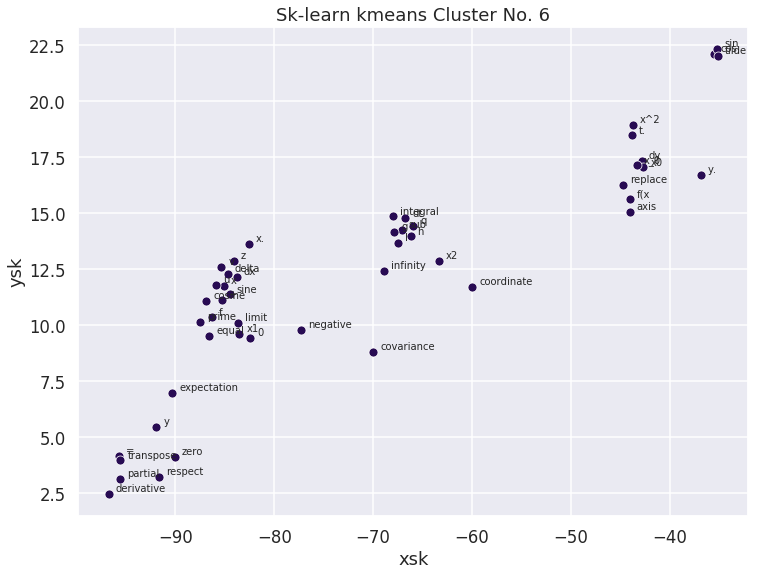

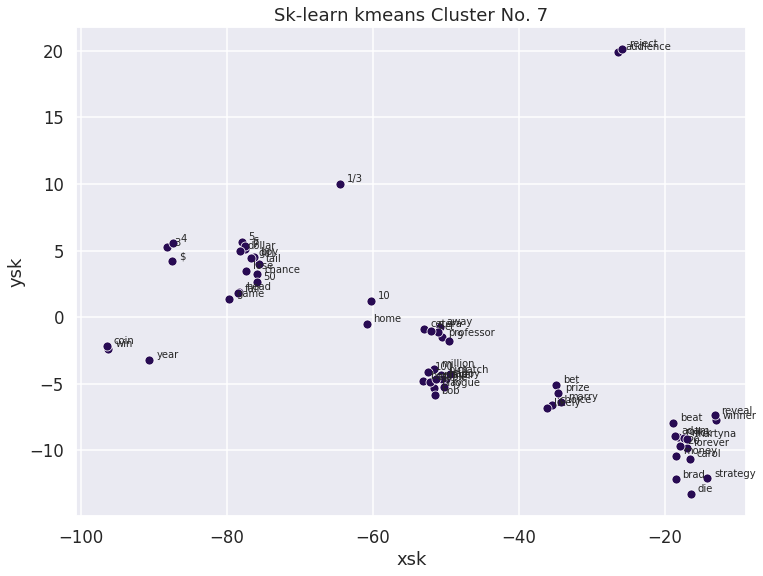

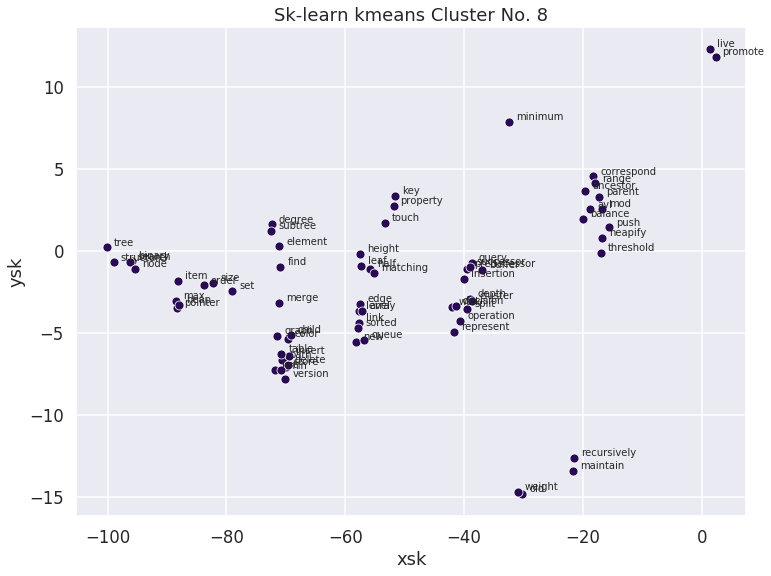

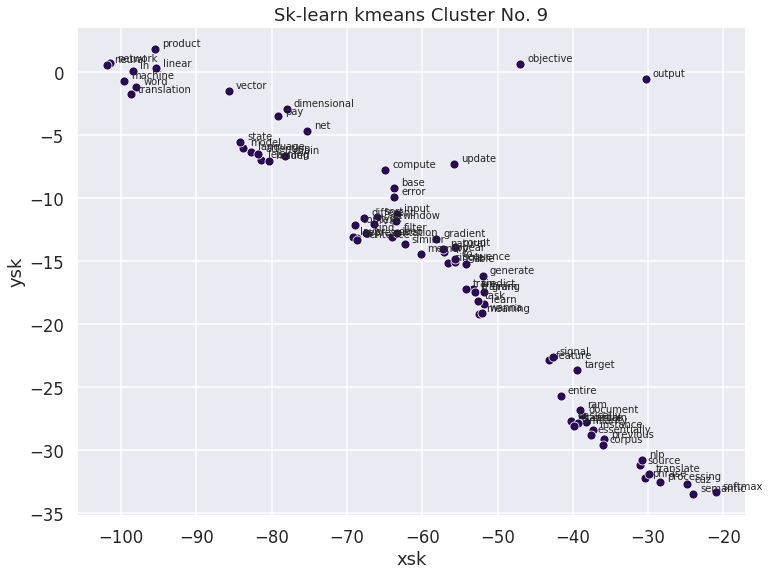

In [796]:
for i in range(10):
    clustern = w_clust[w_clust.sklabels == i]
    plt.figure(figsize=(12,9))
    sns.scatterplot(clustern.xsk,clustern.ysk)
    for label, x, y in zip(clustern.word,clustern.xsk,clustern.ysk):
        plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)
    plt.title('Sk-learn kmeans Cluster No. {}'.format(i))
    plt.show()

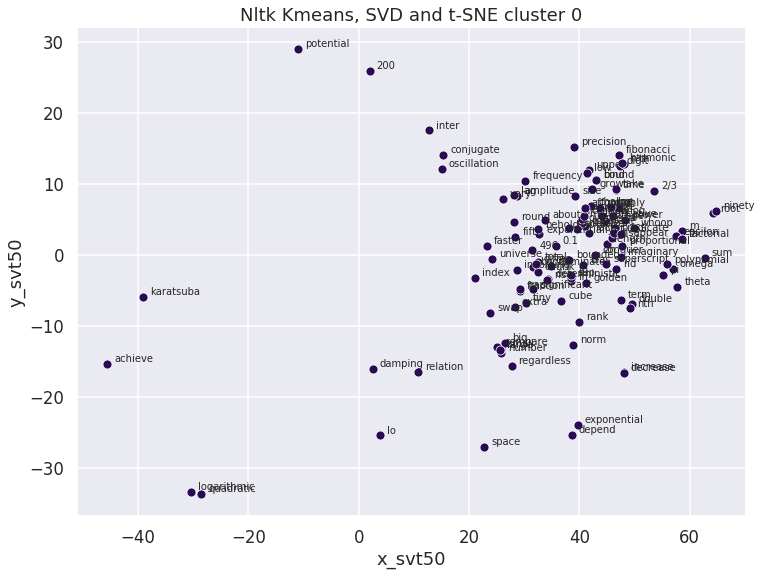

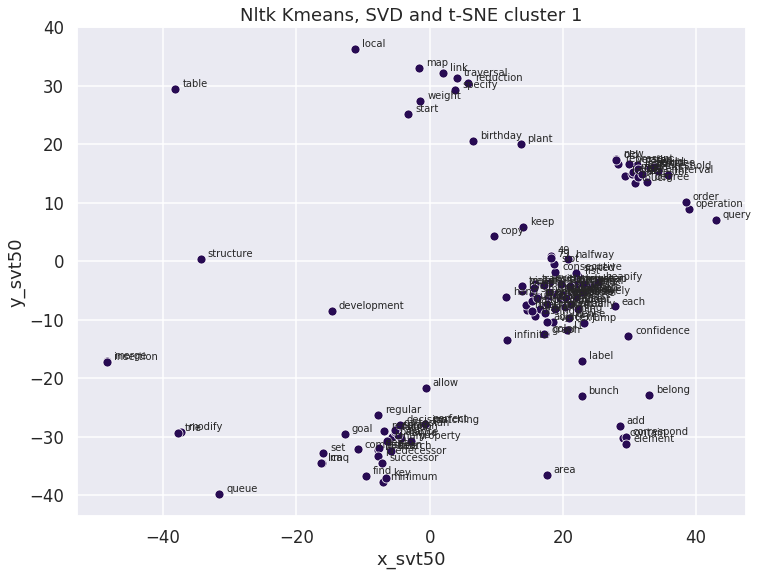

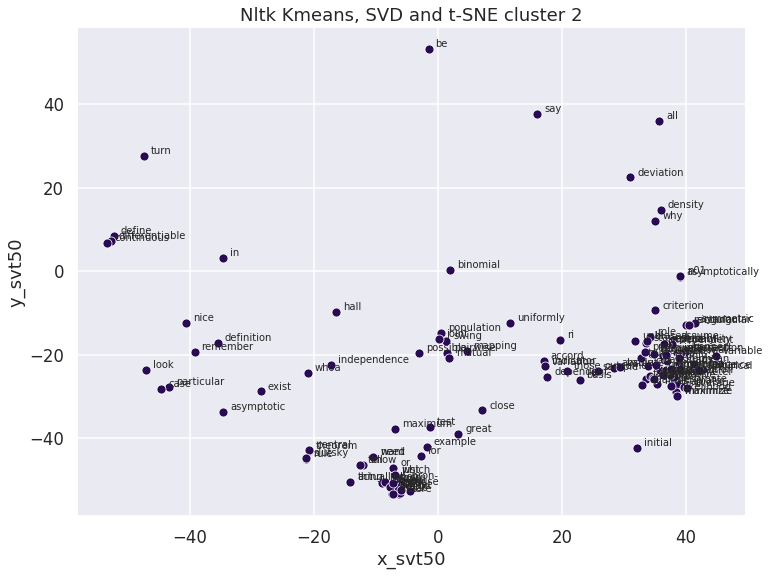

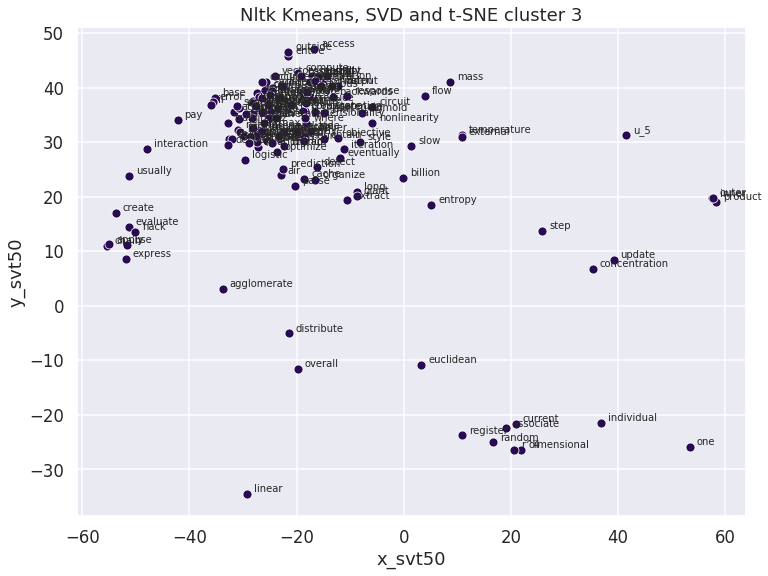

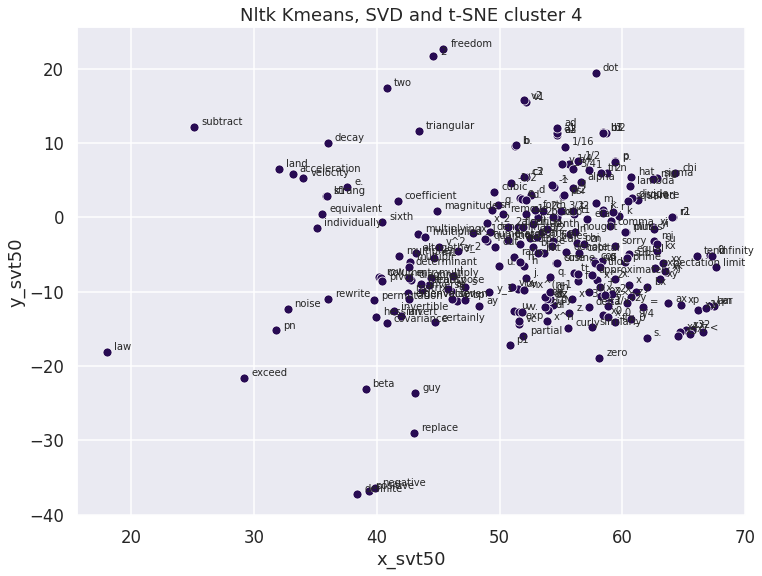

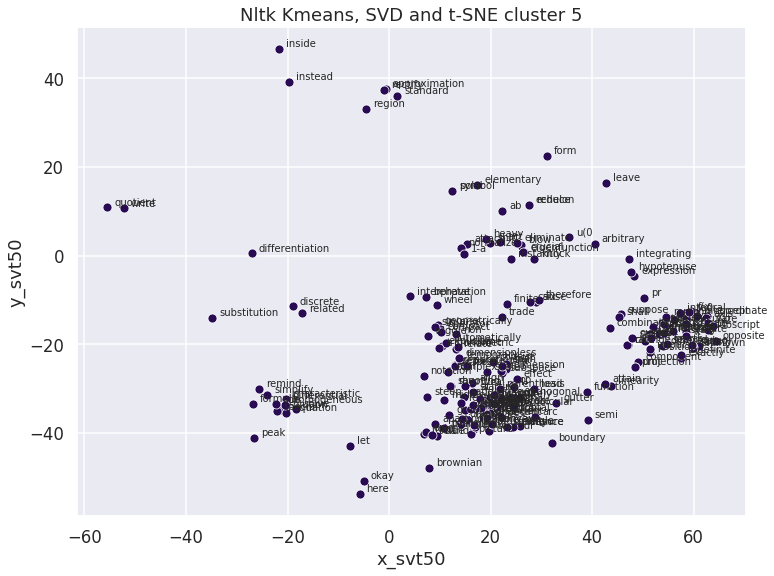

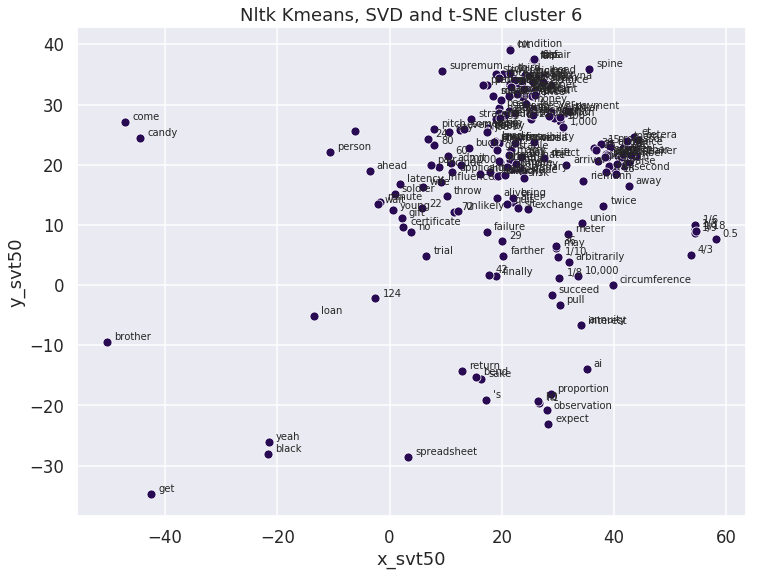

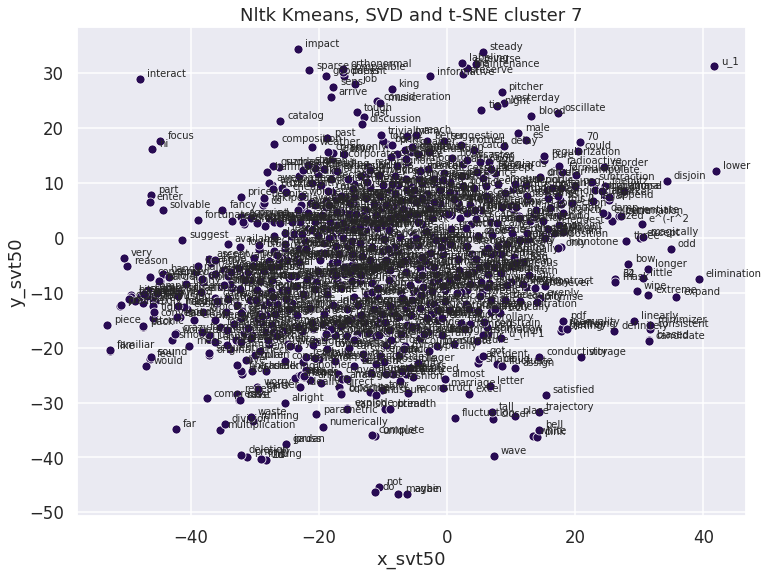

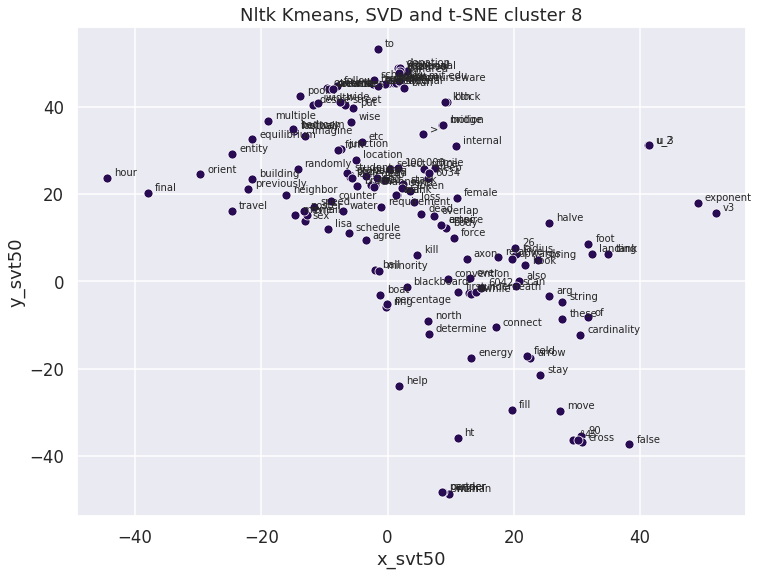

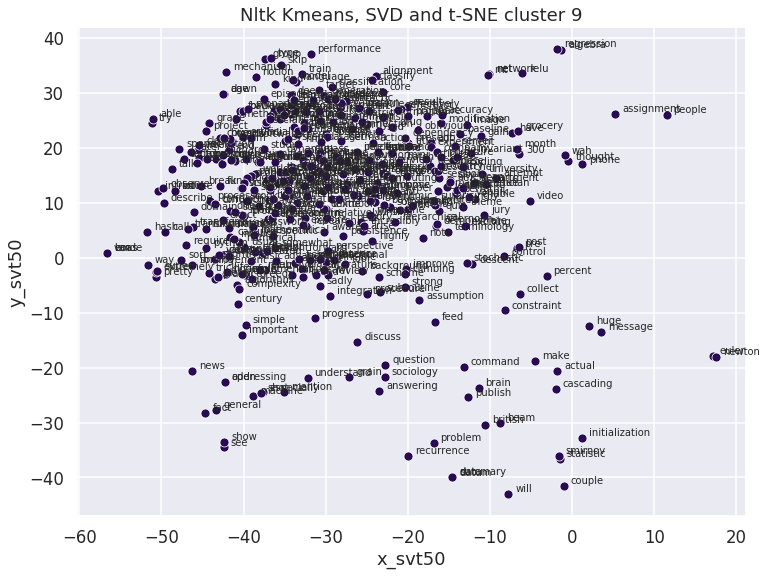

In [797]:
for i in range(10):
    clustern = w_clust[w_clust.cluster == i]
    plt.figure(figsize=(12,9))
    sns.scatterplot(clustern.x_svt50,clustern.y_svt50)
    for label, x, y in zip(clustern.word,clustern.x_svt50,clustern.y_svt50):
        plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)
    plt.title('Nltk Kmeans, SVD and t-SNE cluster {}'.format(i))
    plt.show()

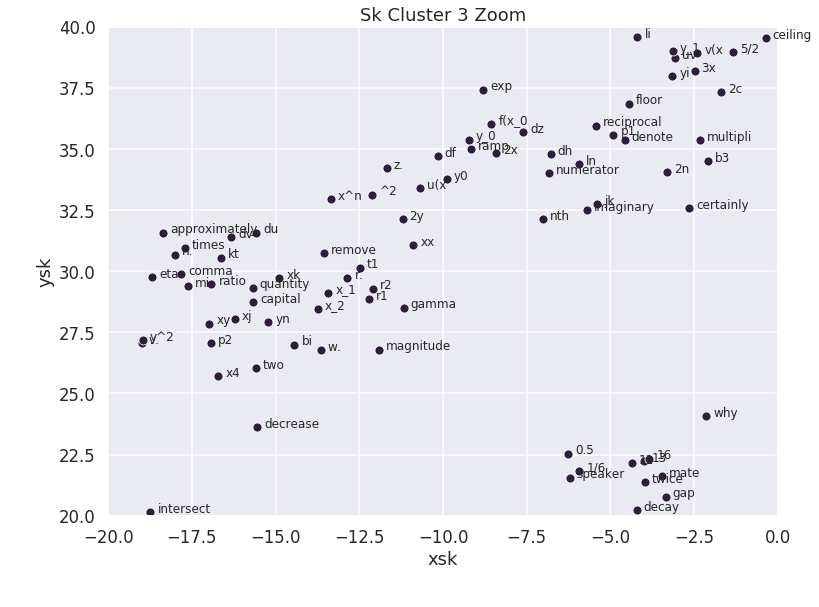

In [745]:
plt.figure(figsize=(12,9))
sns.scatterplot(csk3.xsk,csk3.ysk)
for label, x, y in zip(csk3.word,csk3.xsk,csk3.ysk):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=12)
plt.xlim(-20,0)
plt.ylim(20,40)
plt.title('Sk Cluster 3 Zoom')
plt.show()

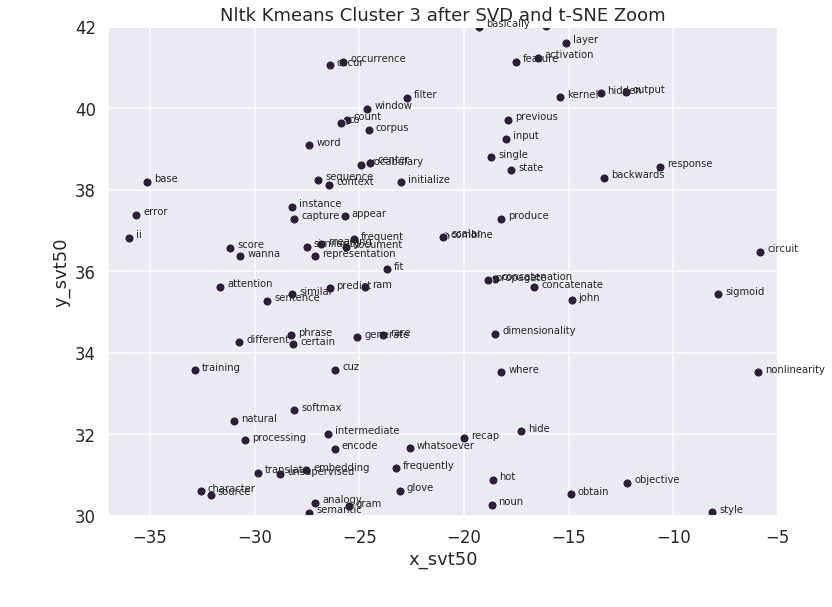

In [744]:
plt.figure(figsize=(12,9))
sns.scatterplot(c3.x_svt50, c3.y_svt50)
for label, x, y in zip(c3.word, c3.x_svt50, c3.y_svt50):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=10)
plt.title('Nltk Kmeans Cluster 3 after SVD and t-SNE Zoom')
plt.xlim(-37,-5)
plt.ylim(30,42)
plt.show()

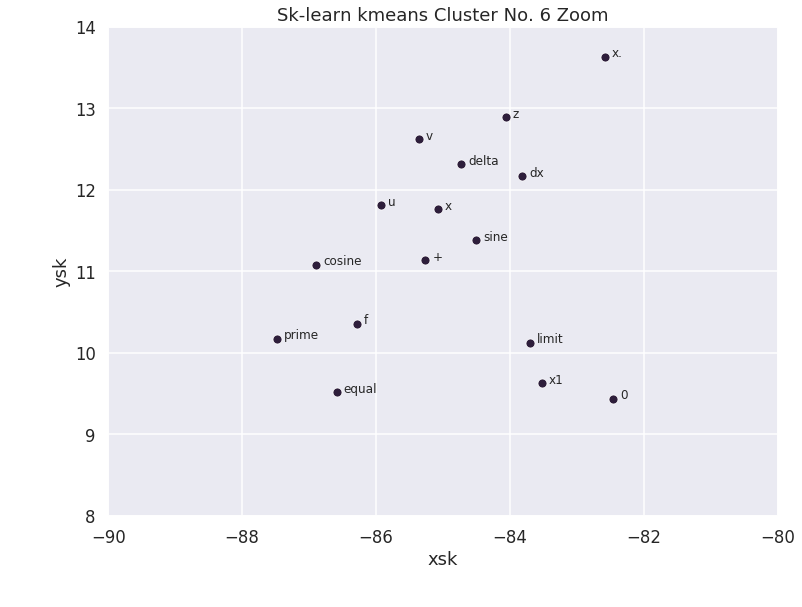

In [743]:
plt.figure(figsize=(12,9))
sns.scatterplot(csk6.xsk,csk6.ysk)
for label, x, y in zip(csk6.word,csk6.xsk,csk6.ysk):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=12)
plt.xlim(-90,-80)
plt.ylim(8,14)
plt.title('Sk-learn kmeans Cluster No. 6 Zoom')
plt.show()

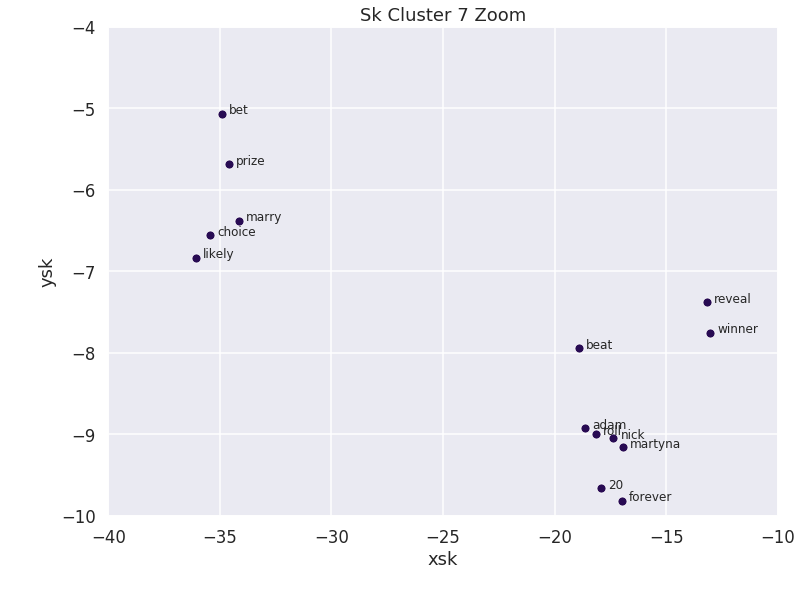

In [805]:
plt.figure(figsize=(12,9))
sns.scatterplot(csk7.xsk,csk7.ysk)
for label, x, y in zip(csk7.word,csk7.xsk,csk7.ysk):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=12)
plt.xlim(-40,-10)
plt.ylim(-10,-4)
plt.title('Sk Cluster 7 Zoom')
plt.show()

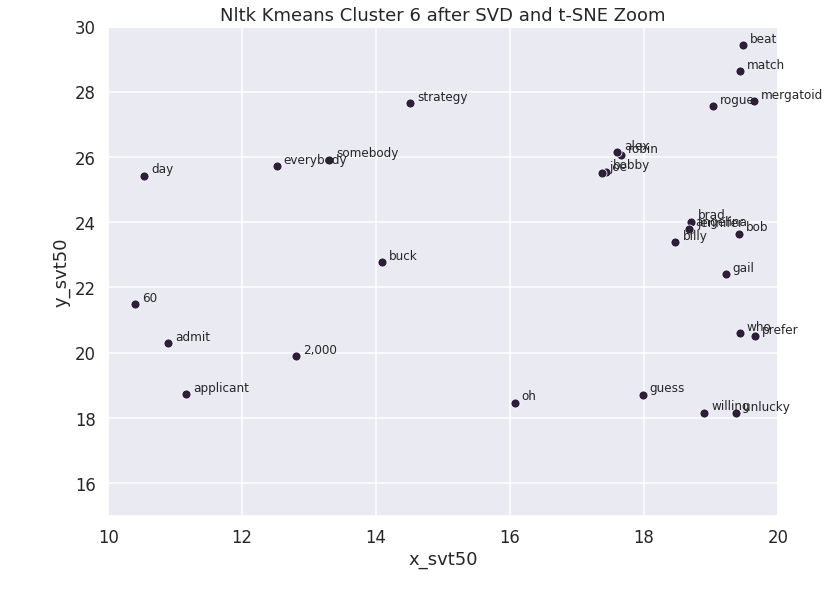

In [749]:
plt.figure(figsize=(12,9))
sns.scatterplot(c6.x_svt50,c6.y_svt50)
for label, x, y in zip(c6.word,c6.x_svt50,c6.y_svt50):
    plt.annotate(label, xy=(x, y), xytext=(7, 3), textcoords='offset points',fontsize=12)
plt.xlim(10,20)
plt.ylim(15,30)
plt.title('Nltk Kmeans Cluster 6 after SVD and t-SNE Zoom')
plt.show()

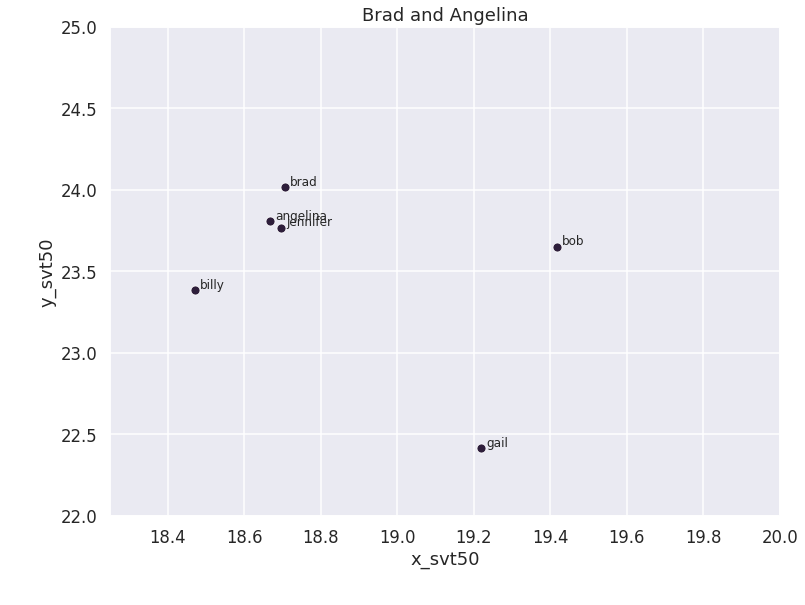

In [750]:
plt.figure(figsize=(12,9))
sns.scatterplot(c6.x_svt50,c6.y_svt50)
for label, x, y in zip(c6.word,c6.x_svt50,c6.y_svt50):
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',fontsize=12)
plt.xlim(18.25,20)
plt.ylim(22,25)
plt.title("Brad and Angelina")
plt.show()

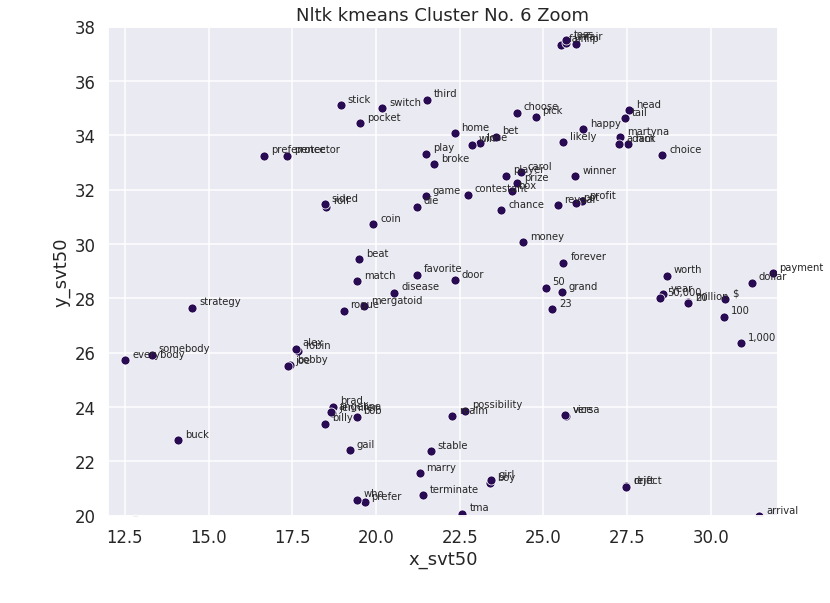

In [808]:
plt.figure(figsize=(12,9))
sns.scatterplot(c6.x_svt50, c6.y_svt50)
for label, x, y in zip(c6.word, c6.x_svt50, c6.y_svt50):
    plt.annotate(label, xy=(x, y), xytext=(7, 3), textcoords='offset points',fontsize=10)
plt.title('Nltk kmeans Cluster No. 6 Zoom')
plt.xlim(12,32)
plt.ylim(20,38)
plt.show()

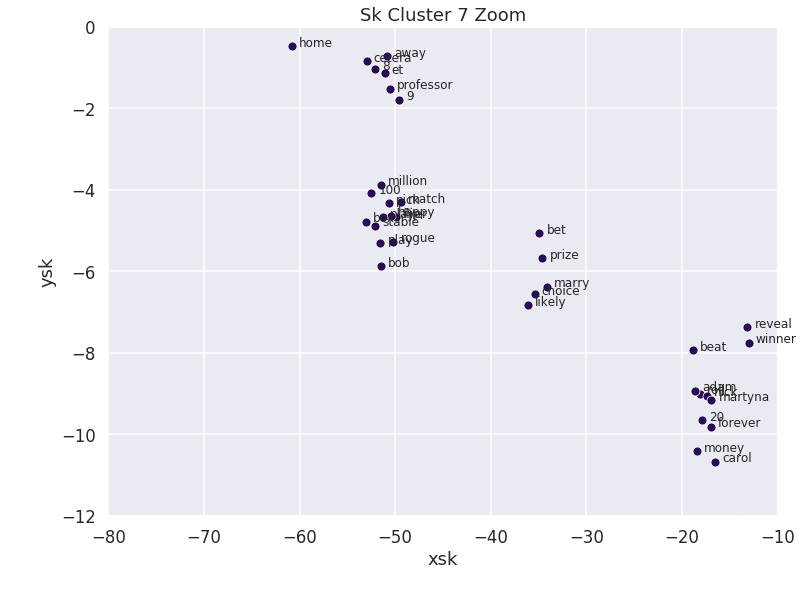

In [812]:
plt.figure(figsize=(12,9))
sns.scatterplot(csk7.xsk,csk7.ysk)
for label, x, y in zip(csk7.word,csk7.xsk,csk7.ysk):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=12)
plt.xlim(-80,-10)
plt.ylim(-12,0)
plt.title('Sk Cluster 7 Zoom')
plt.show()

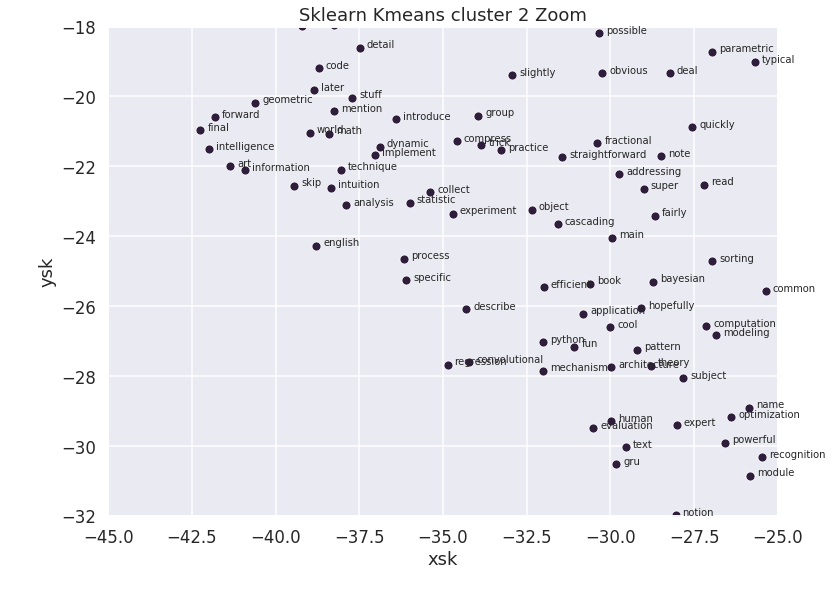

In [752]:
plt.figure(figsize=(12,9))
sns.scatterplot(csk2.xsk,csk2.ysk)
for label, x, y in zip(csk2.word,csk2.xsk,csk2.ysk):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=10)
plt.xlim(-45,-25)
plt.ylim(-32,-18)
plt.title('Sklearn Kmeans cluster 2 Zoom')
plt.show()

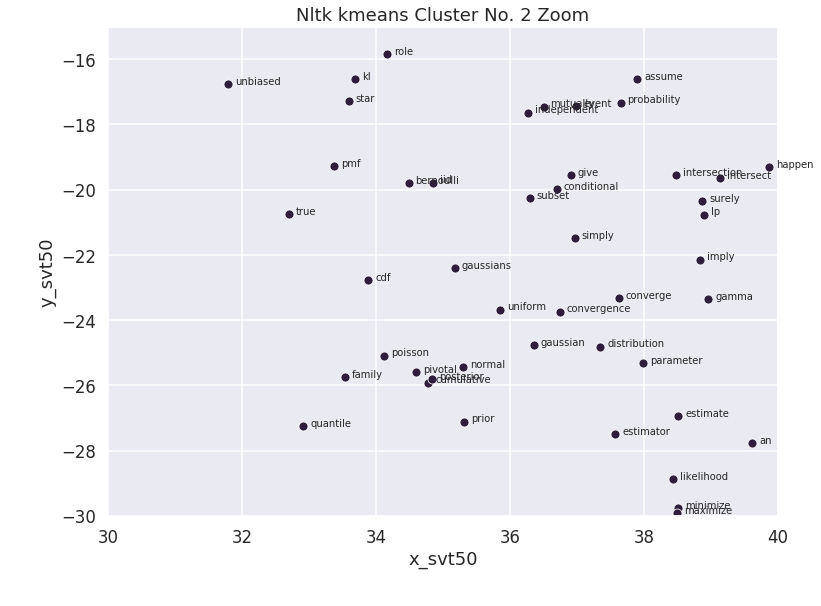

In [754]:
plt.figure(figsize=(12,9))
sns.scatterplot(c2.x_svt50, c2.y_svt50)
for label, x, y in zip(c2.word, c2.x_svt50, c2.y_svt50):
    plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=10)
plt.title('Nltk kmeans Cluster No. 2 Zoom')
plt.xlim(30,40)
plt.ylim(-30,-15)
plt.show()

In [651]:
from sklearn import metrics
#all data
clusters3 = [2,4,8,10,11,15,20]
for i in clusters3:
    print("Number of defined clusters: {}".format(i))
    modelk = cluster.KMeans(n_clusters=i, random_state=None).fit(X)
    labels = model.labels_
    print(metrics.silhouette_score(X, labels, metric='euclidean'))

Number of defined clusters: 2
0.3958273
Number of defined clusters: 4
0.25456494
Number of defined clusters: 8
0.24409746
Number of defined clusters: 10
0.15605918
Number of defined clusters: 11
0.110175826
Number of defined clusters: 15
0.02529649
Number of defined clusters: 20
0.017832521


It appears that a lower number of clusters would be better.

In [688]:
X.shape

(2743, 300)

So far with the word2vec clustering and visualization it is hard to tell how the clusters are actually forming. There is strong evidence that clusters of words tend to form from certain lectures. Both sklearn cluster 7 and nltk's clustering for 6 contain 'Brad, Angelina, rogue, Jennifer, match',these are from tom leighton's lecture on graph theory. In the same clusters you find carol, prize, winner, which I belive is from tom lieghtons lectures on probability. There is a strong link between these clusters and tom leightons lectures.

Some clusters seem to be more purely mathematical in nature, some seem to be a a mix of mathematics and word problems. Others, such sk learns 6 cluster seems to be heavily calculus influenced, while the zoomed in section of Ntlk cluster 3 is clearly about natrual language processing.

So far we have vectorized the words of the texts, for the assignment, we will use the same techniques for each sentence.

In [850]:
sentences.head()

Professor   Subject                                              sents
0    Auroux  Calculus  [so, let, -pron-, start, right, away, stuff, n...
1    Auroux  Calculus  [so, hopefully, yesterday, recitation, hear, b...
2    Auroux  Calculus                      [how, actually, know, vector]
3    Auroux  Calculus                           [ok, be, vast, majority]
4    Auroux  Calculus  [if, people, hopefully, will, learn, vector, r...

In [851]:
sentences.head()

Professor   Subject                                              sents
0    Auroux  Calculus  [so, let, -pron-, start, right, away, stuff, n...
1    Auroux  Calculus  [so, hopefully, yesterday, recitation, hear, b...
2    Auroux  Calculus                      [how, actually, know, vector]
3    Auroux  Calculus                           [ok, be, vast, majority]
4    Auroux  Calculus  [if, people, hopefully, will, learn, vector, r...

In [762]:
#this function takes two words and a model and plots each word with its 10 most similar words
#it also displays the cluster group from the 10x kmeans cluster
def word_compare(model,word0,word1):
    #create empty vector
    wvec0 = np.empty((0,300), dtype='f')
    wvec1 = np.empty((0,300), dtype='f')
    #create lists with words for labels
    label0 = [word0]
    label1= [word1]
    #get list of similar words
    close_words0 = model.wv.most_similar(word0)
    close_words1 = model.wv.most_similar(word1)
    #add wordvec 
    wvec0 = np.append(wvec0, np.array([model[word0]]), axis=0)
    wvec1 = np.append(wvec1, np.array([model[word1]]), axis=0)
    #add each word vec for each word in close_words
    for wrd_score in close_words0:
        wrd_vector = model[wrd_score[0]]
        label0.append(wrd_score[0])
        wvec0 = np.append(wvec0, np.array([wrd_vector]), axis=0)
    
    for wrd_score in close_words1:
        wrd_vector = model[wrd_score[0]]
        label1.append(wrd_score[0])
        wvec1 = np.append(wvec1, np.array([wrd_vector]), axis=0)
    #instantiate t-SNE to reduce dimentionality 
    tsne = TSNE(n_components=2, early_exaggeration=25, random_state=43)
    np.set_printoptions(suppress=True)
    #get coords
    Y0 = tsne.fit_transform(wvec0)
    Y1 = tsne.fit_transform(wvec1)
    
    x0 = Y0[:, 0]
    y0 = Y0[:, 1]
    x1 = Y1[:, 0]
    y1 = Y1[:, 1]
    #create dataframe
    plotdf = pd.DataFrame()
    #list = word + cluster number from w_clust
    plotdf['label0'] = [ str(i)+' '+str(j) for i,j in zip(label0, [w_clust.cluster[i] for i\
                        in [int(w_clust.index[w_clust['word'] == i ][0]) for i in label0 ] ])]
    plotdf['label1'] = [ str(i)+' '+str(j) for i,j in zip(label1, [w_clust.cluster[i] for i\
                        in [int(w_clust.index[w_clust['word'] == i ][0]) for i in label1 ] ])]
    plotdf['x0'] = x0
    plotdf['y0'] = y0
    plotdf['x1'] = x1
    plotdf['y1'] = y1
       
    plt.figure(figsize=(15,12))
    sns.scatterplot(x='x0',y='y0',color='teal',data=plotdf)
    sns.scatterplot(x='x1',y='y1',color='purple',data=plotdf)
    
    for label, x, y in zip(plotdf.label0,x0,y0):
        plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=16)
    for label, x, y in zip(plotdf.label1, x1, y1):
        plt.annotate(label, xy=(x, y), xytext=(7, 0), textcoords='offset points',fontsize=16)
    plt.legend(labels=[word0,word1])
    plt.title('Word Compare with cluster number')
    plt.show()


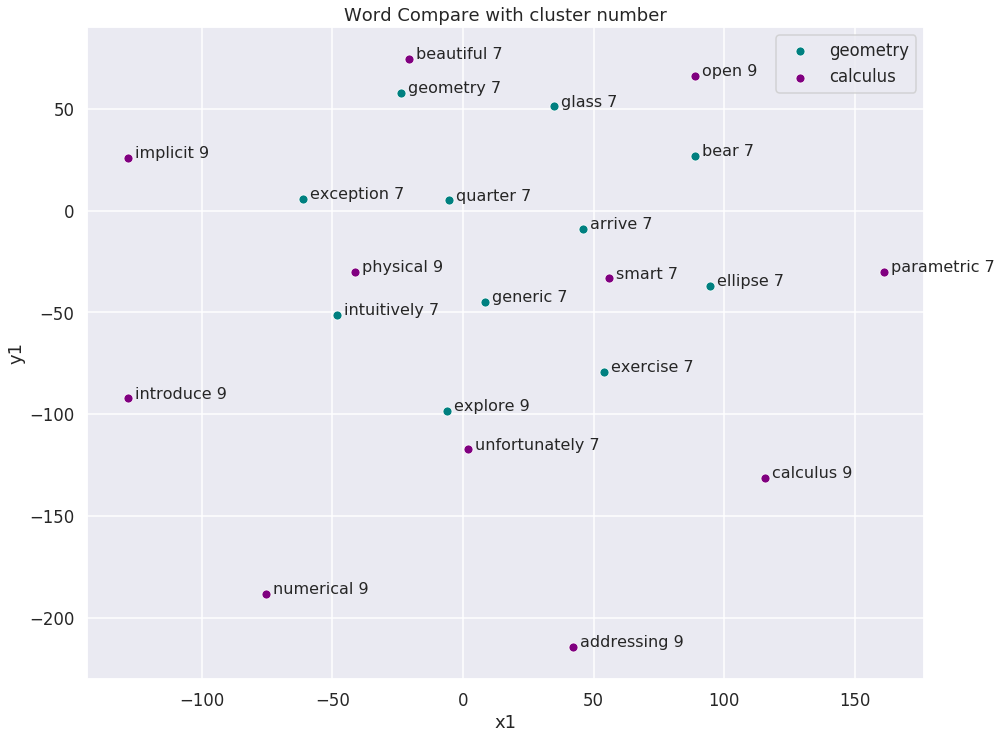

In [846]:
word_compare(model,'geometry','calculus')

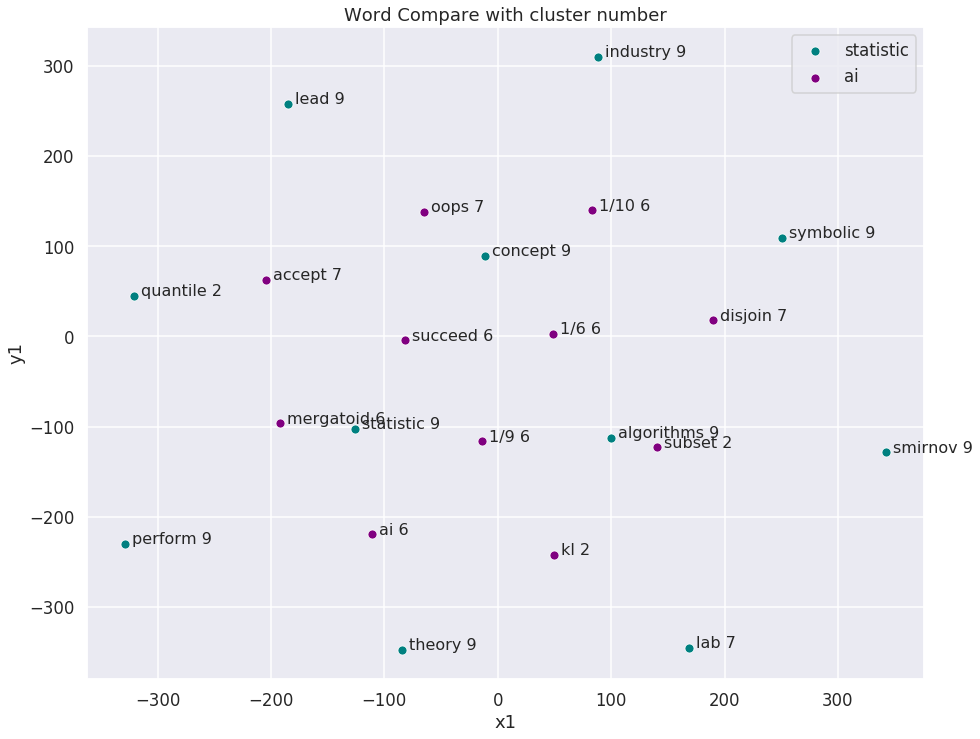

In [764]:
word_compare(model,'statistic','ai')

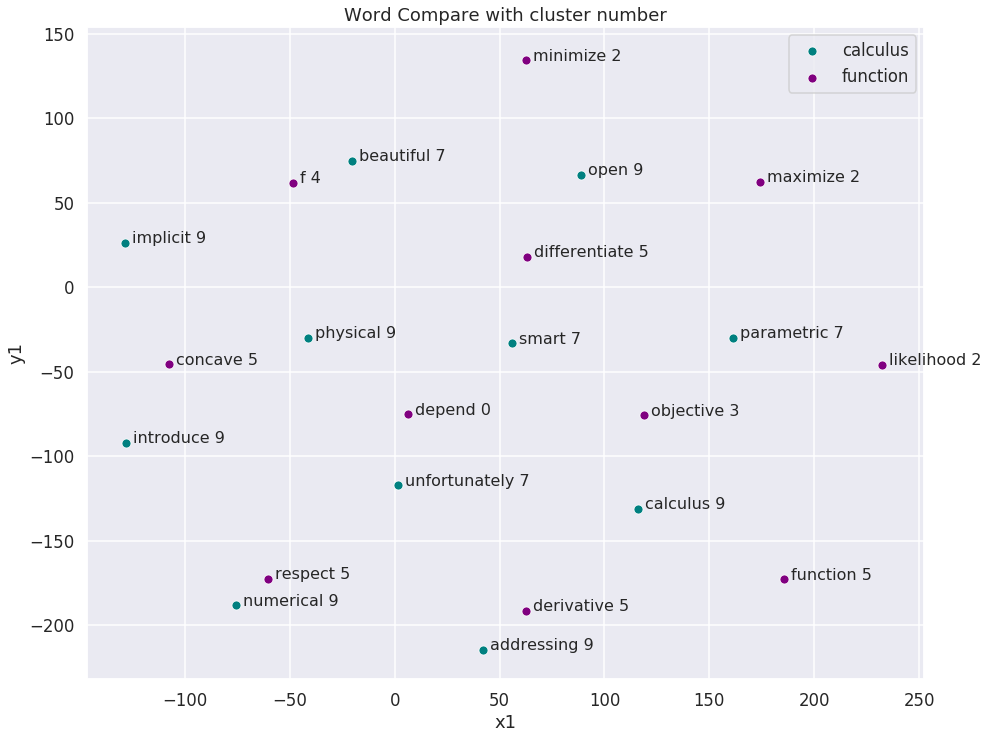

In [765]:
word_compare(model,'calculus','function')

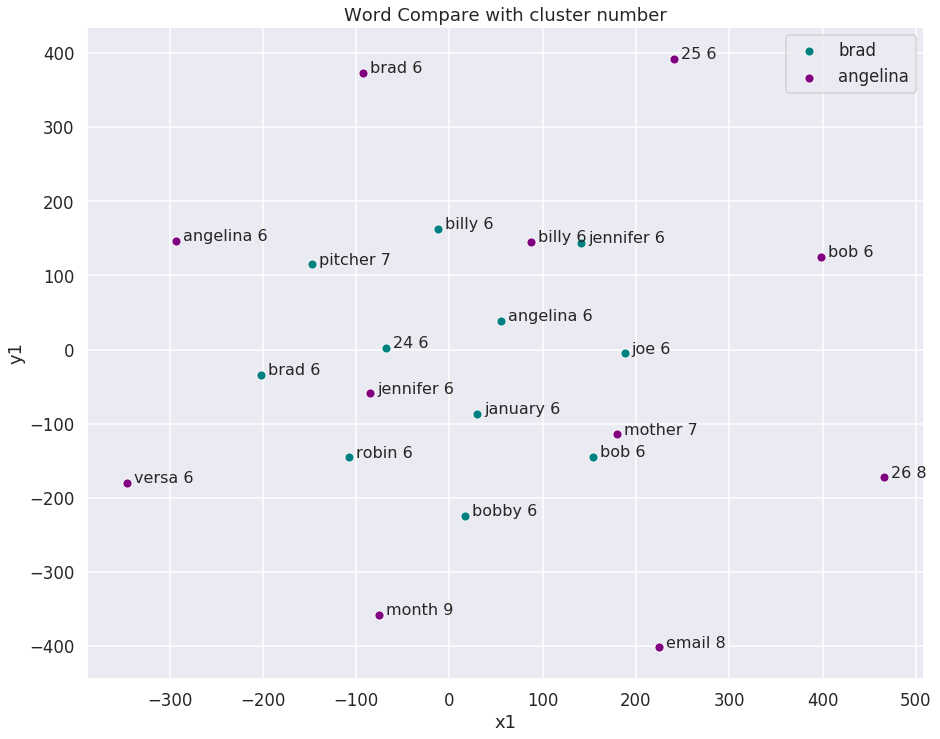

In [766]:
word_compare(model,'brad','angelina')

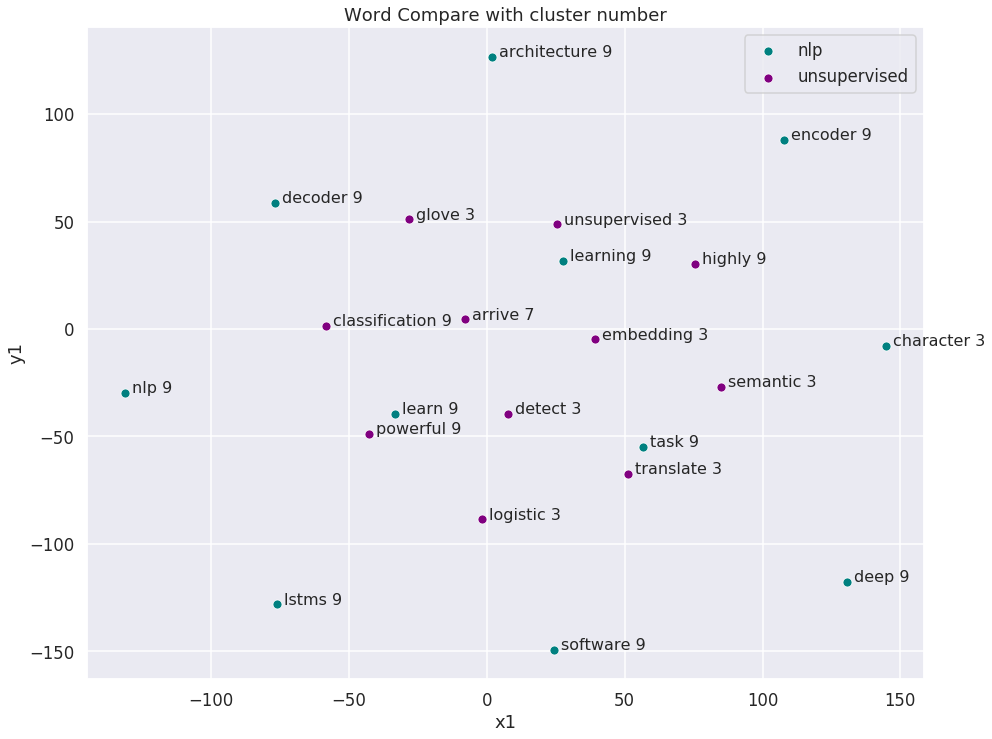

In [768]:
word_compare(model,'nlp','unsupervised')

In [838]:
glo_sents = [ ' '.join(i) for i in sentences.sents]

from utils import (build_coocurrence_matrix,
generate_training_corpus)

ModuleNotFoundError: No module named 'utils'

In [ ]:
import scipy.sparse as sp
voc2id = dict(zip(names, range(len(names))))
rows, cols, vals = [], [], []
for r, d in enumerate(document):
    for e in d:
        if voc2id.get(e) is not None:
            rows.append(r)
            cols.append(voc2id[e])
            vals.append(1)
X = sp.csr_matrix((vals, (rows, cols)))

In [ ]:
Xc = (X.T * X) # coocurrence matrix
Xc.setdiag(0)
print(Xc.toarray())

In [837]:
textfile = open('forglove.txt', 'w')
textfile.write(a)
textfile.close()

(66224, 7943)

In [ ]:
def word_compare(model,word0,word1):
    #create empty vector
    wvec0 = np.empty((0,300), dtype='f')
    wvec1 = np.empty((0,300), dtype='f')
    #create lists with words for labels
    label0 = [word0]
    label1= [word1]
    #get list of similar words
    close_words0 = model.wv.most_similar(word0)
    close_words1 = model.wv.most_similar(word1)
    #add wordvec 
    wvec0 = np.append(wvec0, np.array([model[word0]]), axis=0)
    wvec1 = np.append(wvec1, np.array([model[word1]]), axis=0)
    #add each word vec for each word in close_words
    for wrd_score in close_words0:
        wrd_vector = model[wrd_score[0]]
        label0.append(wrd_score[0])
        wvec0 = np.append(wvec0, np.array([wrd_vector]), axis=0)
    
    for wrd_score in close_words1:
        wrd_vector = model[wrd_score[0]]
        label1.append(wrd_score[0])
        wvec1 = np.append(wvec1, np.array([wrd_vector]), axis=0)
    #instantiate t-SNE to reduce dimentionality 
    tsne = TSNE(n_components=2, early_exaggeration=25, random_state=43)
    np.set_printoptions(suppress=True)
    #get coords
    Y0 = tsne.fit_transform(wvec0)
    Y1 = tsne.fit_transform(wvec1)
    
    x0 = Y0[:, 0]
    y0 = Y0[:, 1]
    x1 = Y1[:, 0]
    y1 = Y1[:, 1]
    #create dataframe
    plotdf = pd.DataFrame()
    #list = word + cluster number from w_clust
    plotdf['label0'] = [ str(i)+' '+str(j) for i,j in zip(label, [w_clust.cluster[i] for i\
                        in [int(w_clust.index[w_clust['word'] == i ][0]) for i in label ] ])]
    plotdf['label1'] = [ str(i)+' '+str(j) for i,j in zip(label1, [w_clust.cluster[i] for i\
                        in [int(w_clust.index[w_clust['word'] == i ][0]) for i in label1 ] ])]
    plotdf['x0'] = x0
    plotdf['y0'] = y0
    plotdf['x1'] = x1
    plotdf['y1'] = y1
    
    #Get cluster assignment of word
    l_ind0 = [int(w_clust.index[w_clust['word'] == i ][0]) for i in plotdf.label0 ]
    l_ind1 = [int(w_clust.index[w_clust['word'] == i ][0]) for i in plotdf.label1 ]
    
    plotdf[word0] = [w_clust.cluster[i] for i in l_ind0 ]
    plotdf[word1] = [w_clust.cluster[i] for i in l_ind1 ]
    
    plt.figure(figsize=(15,12))
    sns.scatterplot(x='x0',y='y0',color='green',data=plotdf)
    sns.scatterplot(x='x1',y='y1',color='blue',data=plotdf)
    
    for label, x, y in zip(label0,x0,y0):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',fontsize=16)
    for label, x, y in zip(label1, x1, y1):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',fontsize=16)
    plt.legend(labels=[word0,word1])
    
    plt.show()